# Detecting objects using layered surfaces
*Authors: Niels Jeppesen (niejep@dtu.dk), Vedrana Andersen Dahl (vand@dtu.dk)*

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/vedranaa/teaching-notebooks/blob/main/Surfaces_Detect_Objects.ipynb)

This notebook is an extension of the notebook serving as an example for the use of [slgbuilder package](https://github.com/Skielex/slgbuilder), allowing for building and solving Sparse Layered Graphs. Package slgbuilder accompanies our [CVPR paper](https://openaccess.thecvf.com/content_CVPR_2020/papers/Jeppesen_Sparse_Layered_Graphs_for_Multi-Object_Segmentation_CVPR_2020_paper.pdf) where we describe an efficient method for adding interaction terms to graph-cut segmentation problems, in particular to the ordered multi-column graph structure by [Li et al](https://doi.org/10.1109/TPAMI.2006.19). 

Similar approaches, with or without exclusion terms, were used for segmenting human diabetic peripheral nerves [(link)](https://www.nature.com/articles/s41598-020-64430-5), brain axons [(link)](https://www.pnas.org/content/117/52/33649), and muscle fibres [(link)](https://www.sciencedirect.com/science/article/pii/S0010482519300551).

In this notebook we work we work on a small part of a dowscaled slice from one of the volumes described in our paper on human diabetic peripheral nerves. The full dataset contains 11 volumes of size 2048 x 2048 x 2048, which is around $10^{11}$ voxels. The image we work with here has size 128 x 128, which is around $1.6\cdot10^{4}$ pixels, so roughly $10^7$ times less data. One of the full-resolution volumes may be downloaded from [here](https://data.dtu.dk/articles/dataset/Sparse_Layered_Graphs_for_Multi-Object_Segmentation_data_/12462143).

This notebook assumes you are familiar with the basic concept of layered surface detection introduced in the *AIA_DetectLayers* notebook. 

## Load modules and image
Start by installing slgbuilder. This takes a little bit of time, but only needs to be done once per session.

In [ ]:
!pip install slgbuilder -q

     |████████████████████████████████| 89 kB 3.4 MB/s 
     |████████████████████████████████| 112 kB 32.9 MB/s 


Load essential modules for loading, working with, and showing images.

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import PIL
import urllib.request

In [ ]:
# Load image.
url = 'https://qim.compute.dtu.dk/data-repository/demo_data/nerves.png'
image = np.array(PIL.Image.open(urllib.request.urlopen(url))).astype(np.int32)

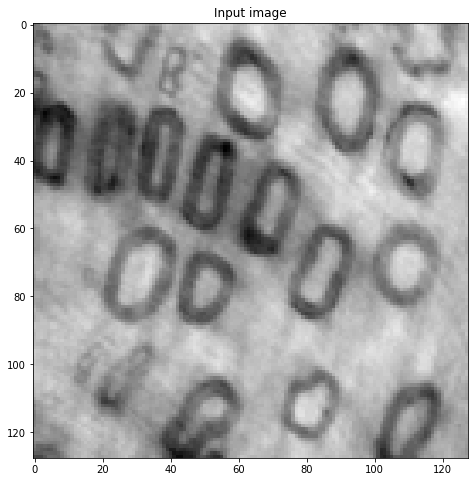

In [ ]:
# Show image.
plt.figure(figsize=(8, 8))
plt.imshow(image, cmap='gray')
plt.title('Input image')
plt.show()

## Try thresholding
Just to see the outcome, try thresholding the image.

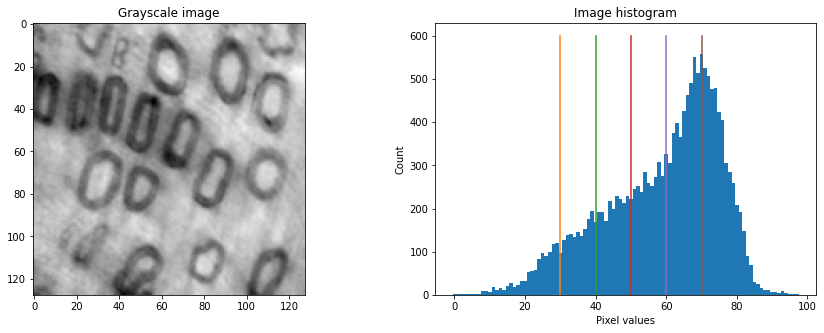

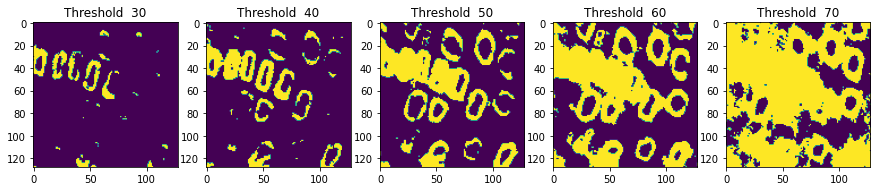

In [ ]:
thresholds = [30, 40, 50, 60, 70]
fig, ax = plt.subplots(1, 2,  figsize=(15, 5))
ax[0].imshow(image, cmap=plt.cm.gray)
ax[0].set_title('Grayscale image')
ax[1].hist(image.ravel(), np.arange(image.min()-0.5, image.max()+1.5))
ax[1].set_xlabel('Pixel values')
ax[1].set_ylabel('Count')
[ax[1].plot([h,h], [0,600]) for h in thresholds]
ax[1].set_title('Image histogram')

fig, ax = plt.subplots(1, 5,  figsize=(15, 5))
for i, th in enumerate(thresholds):
    ax[i].imshow(image < th)
    ax[i].set_title(f'Threshold  {th}')
plt.show()

This shows that despite good data quality in terms of resolution and contrast
To use thresholding-based segmentation we would need to do extensive preprocessing and postprocessing of the results.

## Load nerve centers
To segment individual objects using multi-column graphs, we need to unfold the image around object (nerve) centers. In this notebook, we will load nerve centers. In our [paper on peripheral nerves](https://www.nature.com/articles/s41598-020-64430-5), we detected nerve centers using [InSegt](https://github.com/vedranaa/InSegt). 



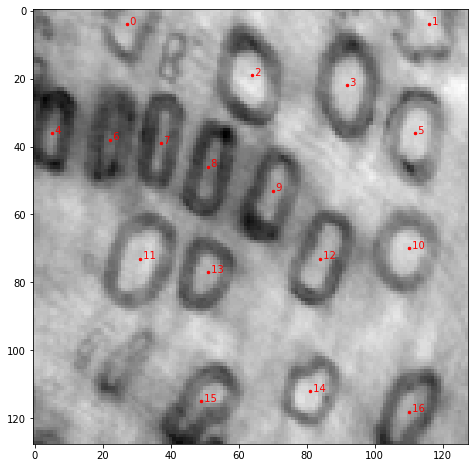

In [ ]:
# Load image with annotated centers.
image_centers = np.array(PIL.Image.open(urllib.request.urlopen(
        url.replace('nerves', 'nerves_centers'))))

# Get center positions.
centers = np.transpose(np.where(image_centers==1))
plt.figure(figsize=(8, 8))
plt.imshow(image, cmap='gray')
plt.scatter(centers[..., 1], centers[..., 0], color='red', s=6)
[plt.text(centers[i, 1], centers[i, 0], ' ' + str(i), color='red') 
        for i in range(len(centers))]
plt.show()


## Unfolding
To detect the objects (nerves) using layered surface detection, we first need to unfold the nerves using a radial resampling.

In [ ]:
from scipy.ndimage.interpolation import map_coordinates

def unfold_image(img, center, max_dists=None, r_min=1, r_max=20, angles=30, steps=15):

    # Sampling angles and radii.
    angles = np.linspace(0, 2*np.pi, angles, endpoint=False)
    distances = np.linspace(r_min, r_max, steps, endpoint=True)
    
    if max_dists is not None:
        max_dists.append(np.max(distances))
    
    # Get angles.
    angles_cos = np.cos(angles)
    angles_sin = np.sin(angles)
    
    # Calculate points positions.
    x_pos = center[0] + np.outer(angles_cos, distances)
    y_pos = center[1] + np.outer(angles_sin, distances)
    
    # Create list of sampling points.
    sampling_points = np.array([x_pos, y_pos]).transpose()
    sampling_shape = sampling_points.shape
    sampling_points_flat = sampling_points.reshape((-1, 2))
    
    # Sample from image.
    samples = map_coordinates(img, sampling_points_flat.transpose(), mode='nearest')
    samples = samples.reshape(sampling_shape[:2])
        
    return samples, sampling_points

Now that we have a function for unfolding images, let's test it. The result should be an unfolded image, for which we can use layer detection.

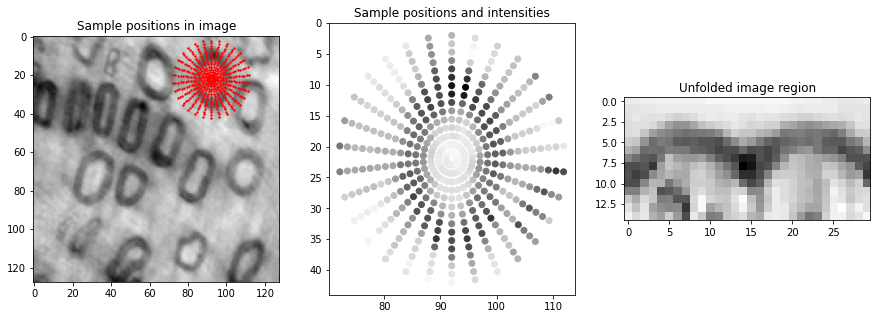

In [ ]:
samples, sample_points = unfold_image(image, centers[3])

plt.figure(figsize=(15, 5))
ax = plt.subplot(1, 3, 1, title='Sample positions in image')
ax.imshow(image, cmap='gray')
ax.scatter(sample_points[..., 1], sample_points[..., 0], s=2, color='red')
ax = plt.subplot(1, 3, 2, title='Sample positions and intensities')
ax.invert_yaxis()
ax.scatter(sample_points[..., 1], sample_points[..., 0], c=samples, cmap='gray')
ax = plt.subplot(1, 3, 3, title='Unfolded image region')
ax.imshow(samples, cmap='gray')
plt.show()

## Detect layers in object
Now that we can unfold the nerves, we can try to use graph cut based layer detection, as introduced in the previous notebook.

Since we want to separate the inner and outer part of the nerve, we will detect two layers per nerve. We will use the gradient image for this.

In [ ]:
from slgbuilder import GraphObject, MaxflowBuilder

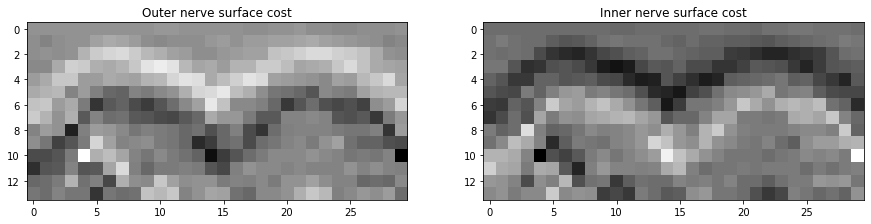

In [ ]:
# Create gradient-based objects.
diff_samples = np.diff(samples, axis=0)
outer_nerve = GraphObject(255 - diff_samples)
inner_nerve = GraphObject(diff_samples)

# Show object data.
plt.figure(figsize=(15, 5))
ax = plt.subplot(1, 2, 1, title='Outer nerve surface cost')
ax.imshow(outer_nerve.data, cmap='gray')
ax = plt.subplot(1, 2, 2, title='Inner nerve surface cost')
ax.imshow(inner_nerve.data, cmap='gray')
plt.show()

The surface will be detected where the pixel costs are low. This corresponds well with the costs for the outer and inner nerves shown above.

Let's detect the layers. We apply boundary cost, smoothness and containment constraints. Here we set both ```min_margin``` and ```max_margin``` constraints for our containment. Then we use ```maxflow``` to find the optimal solution.

In [ ]:
helper = MaxflowBuilder()
helper.add_objects([outer_nerve, inner_nerve])
helper.add_layered_boundary_cost()
helper.add_layered_smoothness(delta=2)
helper.add_layered_containment(outer_nerve, inner_nerve, min_margin=3, max_margin=6)

In [ ]:
flow = helper.solve()
print('Maximum flow/minimum energy:', flow)

Maximum flow/minimum energy: 1454


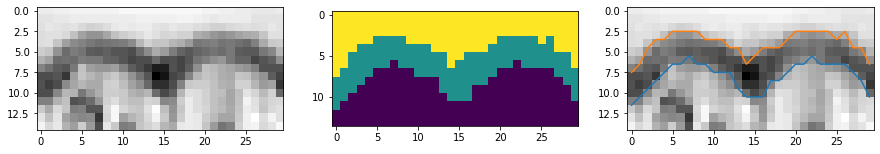

In [ ]:
segmentations = [helper.get_labels(o).astype(np.int32) for o in helper.objects]
segmentation_lines = [np.count_nonzero(s, axis=0) for s in segmentations]

# Draw results.
plt.figure(figsize=(15, 5))
ax = plt.subplot(1, 3, 1)
ax.imshow(samples, cmap='gray')
ax = plt.subplot(1, 3, 2)
ax.imshow(np.sum(segmentations, axis=0))
ax = plt.subplot(1, 3, 3)
ax.imshow(samples, cmap='gray')
for line in segmentation_lines:
    ax.plot(line - 0.5) 
plt.show()

Since we have the original positions (in the original image) for each pixel in our unfolded image, we can easily map the segmentation back to image space.

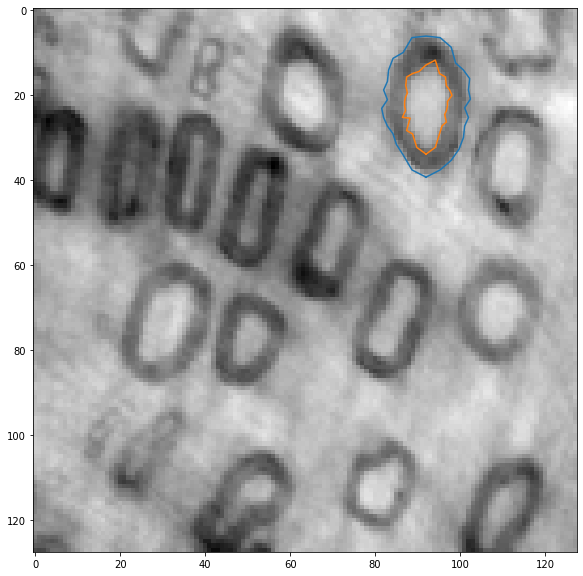

In [ ]:
# Create figure.
plt.figure(figsize=(10, 10))
plt.imshow(image, cmap='gray')

# Draw segmentation lines.
for line in segmentation_lines:

    # Get actual sample points.
    point_indices = tuple(np.asarray([line, np.arange(len(line))]))
    points = sample_points[point_indices]
    
    # Close line.
    points = np.append(points, points[:1], axis=0)

    # Plot points.
    plt.plot(points[:, 1], points[:, 0])

plt.show()

## Detecting multiple objects
We have marked 17 different nerves that we would like to segment in this image. We could segment each of these individually, the same way we segmented the single nerve above. Although it is not the most memory efficient way of segmenting the objects, we could also just add all the objects to the graph at once and get a segmentation for each object. This creates a graph with many "layers", each representing nodes for an object. Because the nodes in each layers only represent a subset of the original image pixels, we call this a Sparse Layered Graph (SLG).

In [ ]:
# Lists for storing nerve objects.
nerve_samples = []
outer_nerves = []
inner_nerves = []

# For each center, create an inner and outer never.
for center in centers:
    # Unfold nerve.
    samples, sample_points = unfold_image(image, center)
    nerve_samples.append(samples)
    
    # Create outer and inner nerve objects.
    diff_samples = np.diff(samples, axis=0)
    diff_sample_points = sample_points[:-1]
    
    outer_nerves.append(GraphObject(255 - diff_samples, diff_sample_points))
    inner_nerves.append(GraphObject(diff_samples, diff_sample_points))

Here we also add the sample positions to the ```GraphObject```s. We will need these later.

In [ ]:
helper = MaxflowBuilder()
helper.add_objects(outer_nerves + inner_nerves)
helper.add_layered_boundary_cost()
helper.add_layered_smoothness(delta=2)

for outer_nerve, inner_nerve in zip(outer_nerves, inner_nerves):
    helper.add_layered_containment(outer_nerve, inner_nerve, min_margin=3, max_margin=6)

In [ ]:
flow = helper.solve()
print('Maximum flow/minimum energy:', flow)

Maximum flow/minimum energy: 24219


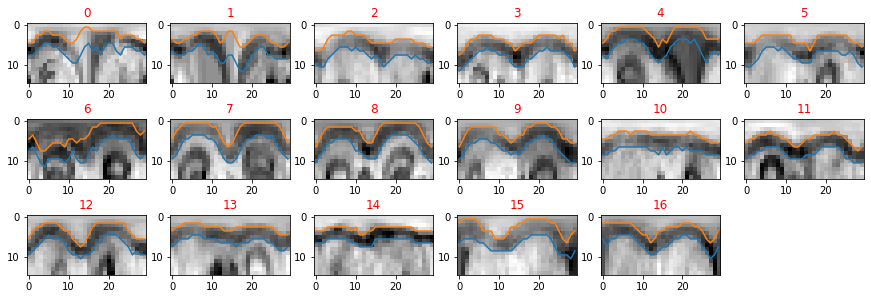

In [ ]:
# Get segmentations.
segmentations = []
for outer_nerve, inner_nerve in zip(outer_nerves, inner_nerves):
    segmentations.append(helper.get_labels(outer_nerve))
    segmentations.append(helper.get_labels(inner_nerve))

segmentation_lines = [np.count_nonzero(s, axis=0) - 0.5 for s in segmentations]

# Draw segmentations.
plt.figure(figsize=(15, 5))
for i, samples in enumerate(nerve_samples):
    ax = plt.subplot(3, len(nerve_samples) // 3 + 1, i + 1)
    ax.imshow(samples, cmap='gray')
    
    ax.plot(segmentation_lines[2*i])
    ax.plot(segmentation_lines[2*i + 1])
    ax.set_title(i, color='red')

plt.show()

While most of the segmentations went well, if we look closely we see that some don't look right. If we draw the lines on the original image, we see the problem.

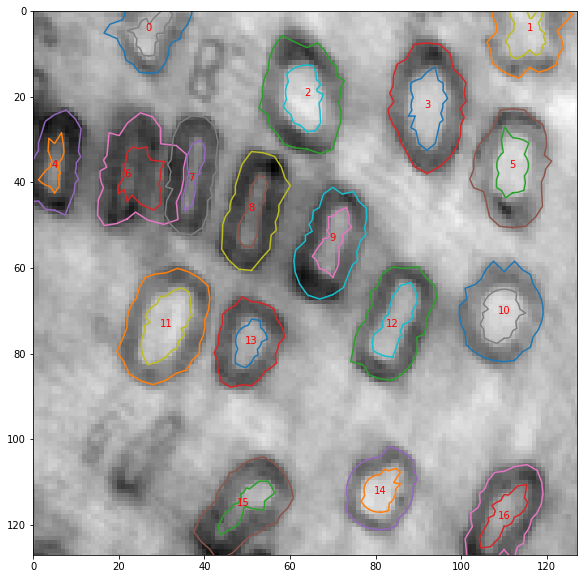

In [ ]:
def draw_segmentations(image, helper, centers):
    """Draw all segmentations for objects in the helper on top of the image."""
    
    # Create figure.
    plt.figure(figsize=(10, 10))
    plt.imshow(image, cmap='gray')
    plt.xlim([0, image.shape[1]-1])
    plt.ylim([image.shape[0]-1, 0])

    # Write center numbers.
    [plt.text(centers[i, 1], centers[i, 0], i, color='red', ha='center', va='center')
             for i in range(len(centers))]

    # Draw segmentation lines.
    for i, obj in enumerate(helper.objects):

        # Get segmentation.
        segment = helper.get_labels(obj)

        # Create line.
        line = np.count_nonzero(segment, axis=0)

        # Get actual points.
        point_indices = tuple(np.asarray([line - 1, np.arange(len(line))]))
        points = obj.sample_points[point_indices]
        # Close line.
        points = np.append(points, points[:1], axis=0)

        # Plot points.
        plt.plot(points[..., 1], points[..., 0])

    plt.show()
    
draw_segmentations(image, helper, centers)

One of the objects is segmented incorrectly overlapping the neighbouring segmentations. Let's zoom in into this area, to cleary see what is causing this to happen.

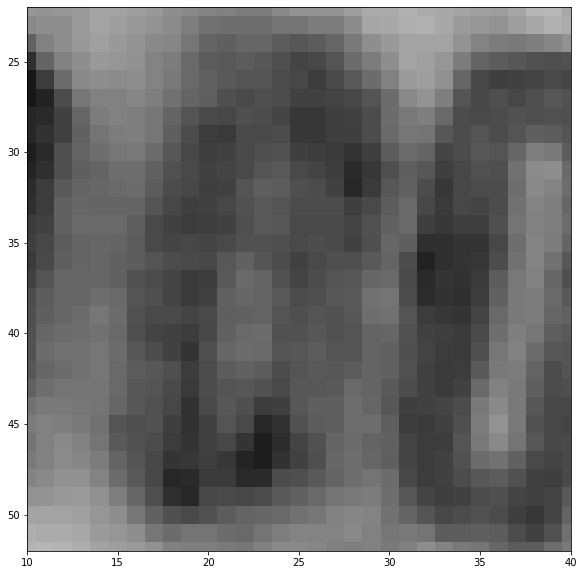

In [ ]:
plt.figure(figsize=(10, 10))
plt.imshow(image, cmap='gray')
plt.xlim([10, 40])
plt.ylim([52, 22])
plt.show()

## Multi-object exclusion
To overcome the issue of overlapping segments, we can add exclusion contraints between all outer nerves. However, exclusion is a so-called *nonsubmodular* energy term, which means it cannot be represented as a single edge in our graph. Luckily there's an algorithm called *QPBO* ([Qudratic Pseudo-Boolean Optimization](https://en.wikipedia.org/wiki/Quadratic_pseudo-Boolean_optimization)) that can help us. 

QPBO creates a complementary graph, alongside the original graph. The complementary graph is inverted, meaning that is has the exact same edges as the original graph, except they are reversed. This means that the graph size is doubled, which makes computation slower and uses more memory. The benefit of QPBO is that we can now add nonsubmodular energies such as exclusion. When coupled with the sparse layered graph structure, we are able to segment many interacting objects using both containment and exclusion interactions.

The ```slgbuilder``` module contains a ```QPBOBuilder``` class, which is very similar to the ```MaxflowBuilder``` we've been using so far. The main difference is that it has functions for adding exclusion. One of these is ```add_layered_exclusion``` which we will now use. We will be using the ```GraphObject```s created earlier.

In [ ]:
from slgbuilder import QPBOBuilder

In [ ]:
helper = QPBOBuilder()
helper.add_objects(outer_nerves + inner_nerves)
helper.add_layered_boundary_cost()
helper.add_layered_smoothness(delta=2)

for outer_nerve, inner_nerve in zip(outer_nerves, inner_nerves):
    helper.add_layered_containment(outer_nerve, inner_nerve, min_margin=3, max_margin=6)

In [ ]:
twice_flow = helper.solve()
print('Two times maximum flow/minimum energy:', twice_flow)

if 2*flow == twice_flow:
    print('QPBO flow is exactly twice the Maxflow flow.')
else:
    print('Something is wrong...')

Two times maximum flow/minimum energy: 48438
QPBO flow is exactly twice the Maxflow flow.


We see that the ```QPBOBuilder``` energy/flow is exactly twice the flow computed by ```MaxflowBuilder``` for a similar problem, which is what we expect, since we double the number of nodes and edges. This is because we have added exactly the same edges/energies on above. This of course also means that the segmentation is exactly the same, hence we haven't fixed the problem yet. 

To avoid the overlapping nerve segments, we add exclusion between all *outer* nerve objects using ```add_layered_exclusion``` and call ```solve``` again. Note that calculating the new maxflow/mincut only requires us to re-evaluate parts of the graph that were changed, potentially making the computation very fast.

In [ ]:
# Add exclusion constraints between all pairs of outer nerves.
for i in range(len(outer_nerves)):
    for j in range(i + 1, len(outer_nerves)):
        helper.add_layered_exclusion(outer_nerves[i], outer_nerves[j], margin=3)

In [ ]:
twice_flow = helper.solve()
print('Two times maximum flow/minimum energy:', twice_flow)

Two times maximum flow/minimum energy: 48580


We see that adding the new constraints has increased the energy. This makes sense, since our constraints are forcing a solution that is suboptimal from the perspective of the costs. However, our prior knowledge tells us that nerves cannot overlap, so even if cost is lowest for the solution with the overlap, we know this is not the case, and we want to consider only solutions without overlap, despite higher cost.

Let's draw the segmentation results with exclusion inteactions.

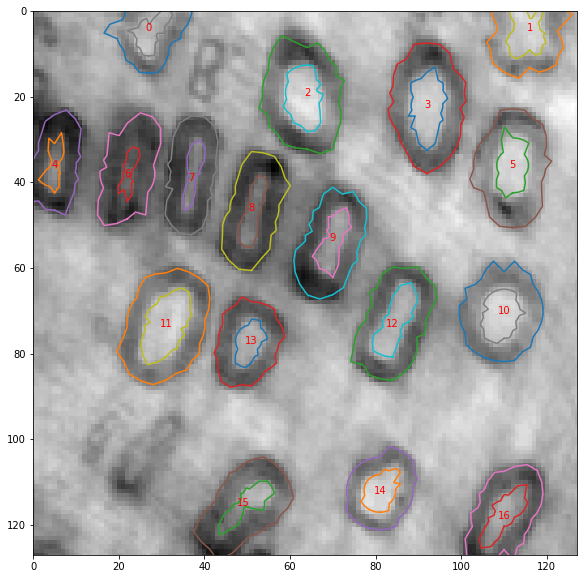

In [ ]:
draw_segmentations(image, helper, centers)

## In-region cost
So far we've only been using on-surface cost computed as the gradient of the unfolded images. However, the pixel intensity between the surfaces may also provide valuable information. This may be added to the model as an in-region cost introduced by [Haeker et al](https://doi.org/10.1007/978-3-540-73273-0_50). In this segmentation problem we notice that each region (area between the layers/object boundaries) has different mean intensities. Generally the nerves are blight inside, while the outer part in dark. The background is also bright.

If the mean intensities of the different objects were relatively consistent, we could use the pixel intensities as in-region costs in our model. Our image has strong gradients while mean intensities vary across the image, so adding in-region costs will not improve the segmentation. Still, let's try it and see how it changes the segmentation. The ```beta``` value is used to scale the influence of the region information compared to the gradient information previously added through the ```add_layered_boundary_cost```. To add region cost for an object we use the ```add_layered_region_cost```.

In [ ]:
mu_inside = 90
mu_ring = 70
mu_outside = 90
beta = 0.1

for samples, outer_nerve, inner_nerve in zip(nerve_samples, outer_nerves, inner_nerves):
    samples = samples[:-1]
    
    inside_cost = np.abs(samples - mu_inside) * beta
    ring_cost = np.abs(samples - mu_ring) * beta
    outside_cost = np.abs(samples - mu_outside) * beta
    
    helper.add_layered_region_cost(inner_nerve, ring_cost, inside_cost)
    helper.add_layered_region_cost(outer_nerve, outside_cost, ring_cost)

In [ ]:
twice_flow = helper.solve()
print('Two times maximum flow/minimum energy:', twice_flow)

Two times maximum flow/minimum energy: 62736


In [ ]:
draw_segmentations(image, helper, centers)

In some areas the results improve slightly, however for areas where the intensities are far from the mean instensities of the region the region cost may lead to a less accurate segmentation.